# Explore Cached Data

In [2]:
import networkx as nx
from network import add_edge, add_node
from pathlib import Path
import json
from typing import Optional
from network import PlayerNode, GameEdge, PlayerDetails

## Pull Cached Data

In [3]:
CACHE_PATH = Path("../data_cache/")
GAME_TYPE = "chess_rapid"

In [4]:
def get_player_profile(username: str) -> Optional[dict]:
    """Get the player profile for a given username.

    Args:
        username (str): The username of the player.

    Returns:
        dict: The player profile.
    """
    cache_file = CACHE_PATH / f"get_player_profile/{username}.json"
    if cache_file.exists():
        with open(cache_file, "r") as f:
            return json.load(f)
    return None

def get_player_stats(username: str) -> Optional[dict]:
    """Get the player stats for a given username.

    Args:
        username (str): The username of the player.

    Returns:
        dict: The player stats.
    """
    cache_file = CACHE_PATH / f"get_player_stats/{username}.json"
    if cache_file.exists():
        with open(cache_file, "r") as f:
            return json.load(f)
    return None

def get_player_data(username: str) -> Optional[PlayerNode]:
    """Get the player data for a given username.

    Args:
        username (str): The username of the player.

    Returns:
        PlayerNode: The player node object.
    """
    profile = get_player_profile(username)
    if profile is None:
        return None
    profile = profile.get("player")
    
    stats = get_player_stats(username)
    if stats is None:
        return None
    stats = stats.get("stats").get(GAME_TYPE)
    if stats is None:
        return None

    return PlayerNode(
        uid=profile.get("player_id"),
        name=profile.get("name"),
        username=profile.get("username"),
        country=profile.get("country").split("/")[-1],
        rating=stats.get("last", {}).get("rating", 0),
    )

In [5]:
def get_game_data(game: dict) -> Optional[GameEdge]:
    try:
        return GameEdge(
            pgn=game.get("pgn", ""),
            time_control=game.get("time_control", ""),
            time_class=game.get("time_class", ""),
            rules=game.get("rules", ""),
            accuracies=game.get("accuracies", {}),
            eco_code=game.get("eco", ""),
            white=PlayerDetails(
                username=game["white"]["username"],
                rating=game["white"].get("rating", 0),
                result=game["white"]["result"],
                uid=game["white"]["uuid"],
            ),
            black=PlayerDetails(
                username=game["black"]["username"],
                rating=game["black"].get("rating", 0),
                result=game["black"]["result"],
                uid=game["black"]["uuid"],
            ),
            start_time=game.get("start_time", 0),
            end_time=game.get("end_time", 0),
        )
    except:
        return None

In [6]:
def add_edges_from_json_files(graph, path):
    for file in path.glob('*.json'):
        try:
            content = file.read_text().strip()
            if not content:
                print(f"Skipping empty file: {file}")
                continue
            games = json.loads(content)['games']
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from file {file}: {e}")
            continue
        
        for game in games:
            game_data = get_game_data(game)
            if game_data is None:
                continue
            try:
                white = get_player_data(game_data.white.username)
                black = get_player_data(game_data.black.username)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {file}: {e}")
                continue
            if white is None or black is None:
                continue
            graph = add_edge(graph, white, black, [game_data])
    return graph

g = add_edges_from_json_files(nx.Graph(), (CACHE_PATH / 'get_player_games_by_month/'))
g

Error decoding JSON from file ../data_cache/get_player_games_by_month/eagle_2019_2024_10.json: Expecting value: line 1 column 1 (char 0)


In [7]:
g.number_of_nodes(), g.number_of_edges()

(19922, 71402)

## Find Waldo!

In order to test our analysis, the following fake data will be injected.

In [123]:
fake_g = g.copy()

In [ ]:
import random

fake_players = [
    {
        "uid": 99999999,
        "name": "FAKE PLAYER",
        "username": "findwaldo1",
        "country": "US",
        "rating": 3000,
    },
    {
        "uid": 99999998,
        "name": "FAKE PLAYER",
        "username": "findwaldo2",
        "country": "IN",
        "rating": 400,
    },
    {
        "uid": 99999997,
        "name": "FAKE PLAYER",
        "username": "findwaldo3",
        "country": "US",
        "rating": 1750,
    },
    {
        "uid": 99999996,
        "name": "FAKE PLAYER",
        "username": "findwaldo4",
        "country": "IN",
        "rating": 2500,
    },
    {
        "uid": 99999995,
        "name": "FAKE PLAYER",
        "username": "findwaldo5",
        "country": "US",
        "rating": 750,
    },
]


def create_fake_game_data(player: PlayerNode, opponent: PlayerNode) -> GameEdge:
    white = player if random.random() < 0.5 else opponent
    black = player if white == opponent else player

    return GameEdge(
        pgn='[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.10.07"]\n[Round "-"]\n[White "rocker52"]\n[Black "Ronin131313"]\n[Result "1-0"]\n[CurrentPosition "4rrk1/2p2p2/p2p1b1p/1p4p1/4P1P1/1PP3B1/P1BN3K/R7 b - -"]\n[Timezone "UTC"]\n[ECO "A40"]\n[ECOUrl "https://www.chess.com/openings/Queens-Pawn-Opening-Horwitz-Defense-2.Nf3"]\n[UTCDate "2024.10.07"]\n[UTCTime "18:46:51"]\n[WhiteElo "781"]\n[BlackElo "770"]\n[TimeControl "60"]\n[Termination "rocker52 won on time"]\n[StartTime "18:46:51"]\n[EndDate "2024.10.07"]\n[EndTime "18:48:56"]\n[Link "https://www.chess.com/game/live/119950300318"]\n\n1. Nf3 {[%clk 0:01:00]} 1... e6 {[%clk 0:00:57.6]} 2. d4 {[%clk 0:00:59.8]} 2... Qf6 {[%clk 0:00:57]} 3. d5 {[%clk 0:00:59.4]} 3... exd5 {[%clk 0:00:55.8]} 4. Qxd5 {[%clk 0:00:57.8]} 4... Bd6 {[%clk 0:00:53.1]} 5. Qe4+ {[%clk 0:00:56.5]} 5... Qe7 {[%clk 0:00:50.5]} 6. Qxe7+ {[%clk 0:00:55.3]} 6... Bxe7 {[%clk 0:00:49.8]} 7. e3 {[%clk 0:00:54.8]} 7... Nf6 {[%clk 0:00:48.9]} 8. Bd3 {[%clk 0:00:53.7]} 8... O-O {[%clk 0:00:47.9]} 9. Ne5 {[%clk 0:00:52.2]} 9... d6 {[%clk 0:00:44.5]} 10. Nc4 {[%clk 0:00:51]} 10... b5 {[%clk 0:00:43.3]} 11. Ncd2 {[%clk 0:00:49]} 11... Nc6 {[%clk 0:00:41.5]} 12. O-O {[%clk 0:00:47.9]} 12... a6 {[%clk 0:00:40.4]} 13. f3 {[%clk 0:00:46.8]} 13... Bf5 {[%clk 0:00:38.5]} 14. e4 {[%clk 0:00:45.2]} 14... Bc8 {[%clk 0:00:37.3]} 15. b3 {[%clk 0:00:42.8]} 15... Nh5 {[%clk 0:00:35.1]} 16. c3 {[%clk 0:00:40.6]} 16... Nf4 {[%clk 0:00:33.7]} 17. Bc2 {[%clk 0:00:36.9]} 17... Bh3 {[%clk 0:00:28.6]} 18. Rf2 {[%clk 0:00:32.1]} 18... Bxg2 {[%clk 0:00:25.4]} 19. Rxg2 {[%clk 0:00:30.8]} 19... Nxg2 {[%clk 0:00:24.6]} 20. Kxg2 {[%clk 0:00:30.3]} 20... Bh4 {[%clk 0:00:23.5]} 21. h3 {[%clk 0:00:28.4]} 21... Ne5 {[%clk 0:00:22.4]} 22. Nf1 {[%clk 0:00:25.5]} 22... Rae8 {[%clk 0:00:21.5]} 23. Bf4 {[%clk 0:00:23.3]} 23... Ng6 {[%clk 0:00:19.5]} 24. Bg3 {[%clk 0:00:21]} 24... Bf6 {[%clk 0:00:17.2]} 25. f4 {[%clk 0:00:18.4]} 25... Bd8 {[%clk 0:00:13.8]} 26. f5 {[%clk 0:00:17.2]} 26... Ne7 {[%clk 0:00:13.2]} 27. Ne3 {[%clk 0:00:14.8]} 27... h6 {[%clk 0:00:10.2]} 28. Nd2 {[%clk 0:00:12.7]} 28... g6 {[%clk 0:00:06.5]} 29. f6 {[%clk 0:00:11.2]} 29... Nc6 {[%clk 0:00:05.4]} 30. Bh4 {[%clk 0:00:09]} 30... Ne5 {[%clk 0:00:03.3]} 31. Ng4 {[%clk 0:00:06.5]} 31... Nxg4 {[%clk 0:00:01.5]} 32. hxg4 {[%clk 0:00:06]} 32... g5 {[%clk 0:00:00.8]} 33. Bg3 {[%clk 0:00:04.7]} 33... Bxf6 {[%clk 0:00:00.1]} 34. Kh2 {[%clk 0:00:03.8]} 1-0\n',
        time_control="60",
        time_class="bullet",
        rules="chess",
        accuracies={},
        eco_code="https://www.chess.com/openings/Queens-Pawn-Opening-Horwitz-Defense-2.Nf3",
        white=PlayerDetails(
            username=white.username,
            rating=white.rating,
            result="win" if white.username == player.username else "timeout",
            uid=white.uid,
        ),
        black=PlayerDetails(
            username=black.username,
            rating=black.rating,
            result="win" if black.username == player.username else "timeout",
            uid=black.uid,
        ),
        start_time=0,
        end_time=1728326936,
    )


for player_node in fake_players:
    player = PlayerNode(**player_node)
    random.shuffle(list(fake_g.nodes()))
    for node in list(fake_g.nodes(data=True))[:random.randint(5, 50)]:
        opponent = PlayerNode(**node[1])
        games = [
            create_fake_game_data(player, opponent)
            for _ in range(random.randint(1, 15))
        ]
        fake_g = add_edge(fake_g, player, opponent, games)

In [ ]:
# Added fakes
fake_g.number_of_nodes() - g.number_of_nodes(), fake_g.number_of_edges() - g.number_of_edges()

(5, 87)

In [ ]:
# Save the fake data

data = nx.node_link_data(fake_g)
with open("network_with_fake.json", "w") as f:
    json.dump(data, f)

/Users/wdonofrio/Documents/Projects/cse6242/project/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


## Store graph as json

In [111]:
# Store networkx graph as one json
data = nx.node_link_data(g)
with open("network.json", "w") as f:
    json.dump(data, f)

# Read networkx graph from json
with open("network.json", "r") as f:
    data = json.load(f)
g = nx.node_link_graph(data)

g.number_of_nodes(), g.number_of_edges()

/Users/wdonofrio/Documents/Projects/cse6242/project/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
/Users/wdonofrio/Documents/Projects/cse6242/project/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


(19922, 71402)

In [112]:
dict(g.nodes(data=True))['kmate28']

{'uid': 82690086,
 'name': None,
 'username': 'kmate28',
 'country': 'EC',
 'rating': 1768}

In [ ]:
list(g.edges(data=True))[0]

('ecztery',
 'zera_kv',
 {'weight': 80,
  'data': [{'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.10.01"]\n[Round "-"]\n[White "eCztery"]\n[Black "Zera_KV"]\n[Result "1-0"]\n[CurrentPosition "7r/3R1p1P/4pk2/5r2/8/1P3P2/P5P1/1K5R b - -"]\n[Timezone "UTC"]\n[ECO "C11"]\n[ECOUrl "https://www.chess.com/openings/French-Defense-Classical-Steinitz-Variation-4...Nfd7-5.Nf3-c5"]\n[UTCDate "2024.10.01"]\n[UTCTime "17:09:01"]\n[WhiteElo "2470"]\n[BlackElo "2443"]\n[TimeControl "60"]\n[Termination "eCztery won on time"]\n[StartTime "17:09:01"]\n[EndDate "2024.10.01"]\n[EndTime "17:11:11"]\n[Link "https://www.chess.com/game/live/121541453405"]\n\n1. d4 {[%clk 0:00:59.9]} 1... e6 {[%clk 0:00:59.2]} 2. Nc3 {[%clk 0:00:59.8]} 2... Nf6 {[%clk 0:00:58.8]} 3. e4 {[%clk 0:00:59.7]} 3... d5 {[%clk 0:00:56.4]} 4. e5 {[%clk 0:00:59]} 4... Nfd7 {[%clk 0:00:54.9]} 5. Nf3 {[%clk 0:00:57.6]} 5... c5 {[%clk 0:00:54.4]} 6. Be3 {[%clk 0:00:56.6]} 6... Nc6 {[%clk 0:00:54]} 7. Qd2 {[%clk 0:00:54.3]} 7

### Top countries by player count

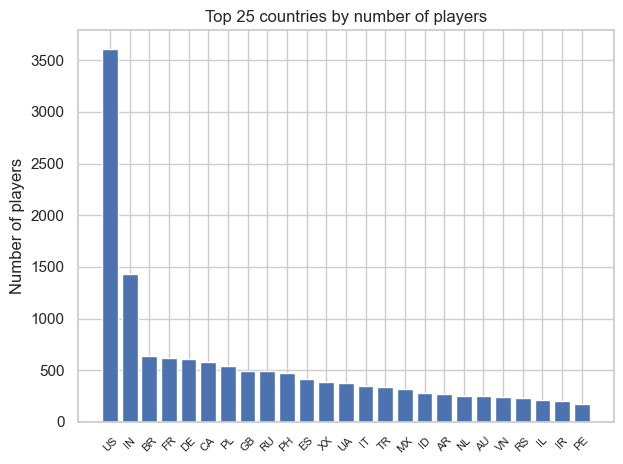

In [139]:
import matplotlib.pyplot as plt
from collections import Counter

countries = Counter([data['country'] for _, data in g.nodes(data=True)])
top_countries = dict(sorted(countries.items(), key=lambda x: x[1], reverse=True)[:25])

plt.bar(top_countries.keys(), top_countries.values())
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.ylabel('Number of players')
plt.title('Top 25 countries by number of players')
plt.tight_layout()
plt.show()

### Top players by degree

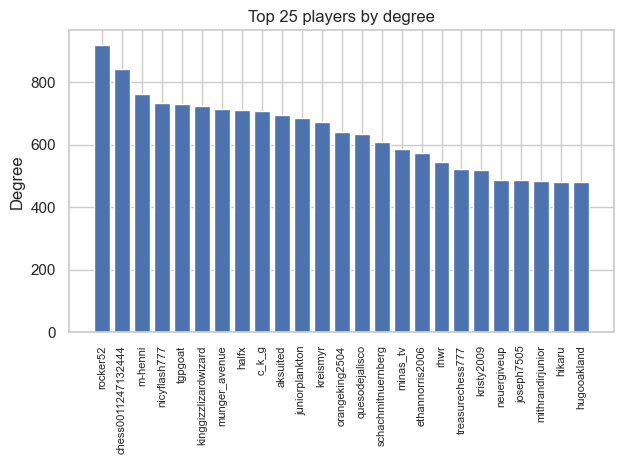

In [ ]:
degrees = dict(g.degree())
top_degrees = dict(sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:25])

plt.bar(top_degrees.keys(), top_degrees.values())
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.ylabel('Degree')
plt.title('Top 25 players by degree')
plt.tight_layout()
plt.show()

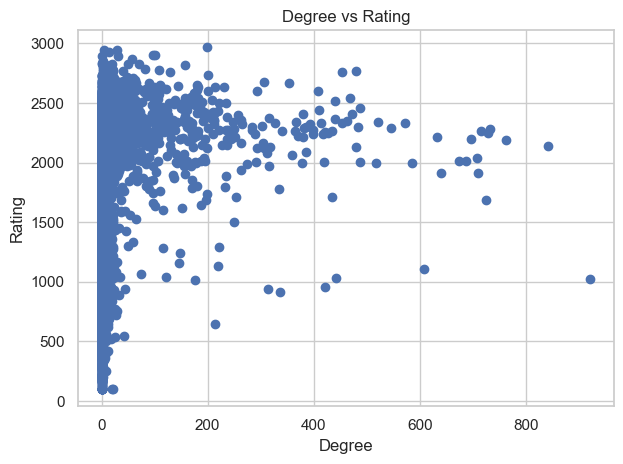

In [141]:
# Correlate degree with rating

ratings = {node: data['rating'] for node, data in g.nodes(data=True)}
degrees = {node: degree for node, degree in g.degree()}
plt.scatter(degrees.values(), ratings.values())
plt.xlabel('Degree')
plt.ylabel('Rating')
plt.title('Degree vs Rating')
plt.tight_layout()
plt.show()


### Top players by game count

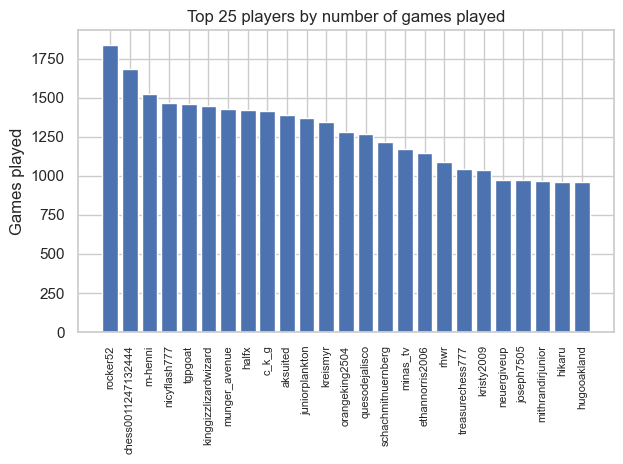

In [ ]:
games_played = {node: sum([len(data) for _, _, data in g.edges(node, data=True)]) for node in g.nodes()}
top_games_played = dict(sorted(games_played.items(), key=lambda x: x[1], reverse=True)[:25])

plt.bar(top_games_played.keys(), top_games_played.values())
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.ylabel('Games played')
plt.title('Top 25 players by number of games played')
plt.tight_layout()
plt.show()

## Get Player - Rating - Result DataFrame

Data is from perspective of "Player" (first entry).

In [147]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_games = []
ratings = {node: data["rating"] for node, data in fake_g.nodes(data=True)}

for node in fake_g.nodes():
    for edge in fake_g.edges(node, data=True):
        player = node
        opponent = edge[1]
        player_rating = ratings[player]
        opponent_rating = ratings[opponent]
        rating_diff = player_rating - opponent_rating
        for game in edge[2]["data"]:
            result = (
                game["white"]["result"]
                if game["white"]["username"] == player
                else game["black"]["result"]
            )
            all_games.append((player, opponent, result, rating_diff))

import pandas as pd

games_df = pd.DataFrame(
    all_games, columns=["player", "opponent", "result", "rating_diff"]
)
games_df

,player,opponent,result,rating_diff
0,ecztery,zera_kv,timeout,-80
1,ecztery,chesschief24,resigned,-64
2,ecztery,nebrabp,timeout,178
3,ecztery,crazymaxxx,checkmated,351
4,ecztery,crazymaxxx,checkmated,351
...,...,...,...,...
291759,findwaldo5,albafantasmal,win,-1288
291760,findwaldo5,albafantasmal,win,-1288
291761,findwaldo5,albafantasmal,win,-1288
291762,findwaldo5,albafantasmal,win,-1288


## Model Logistic Regression

In [148]:

X = np.array([game[3] for game in all_games]).reshape(-1, 1)  # rating difference
y = np.array([1 if game[2] == "win" else 0 for game in all_games])  # result (win=1, lose/draw=0)

Model Accuracy: 0.55


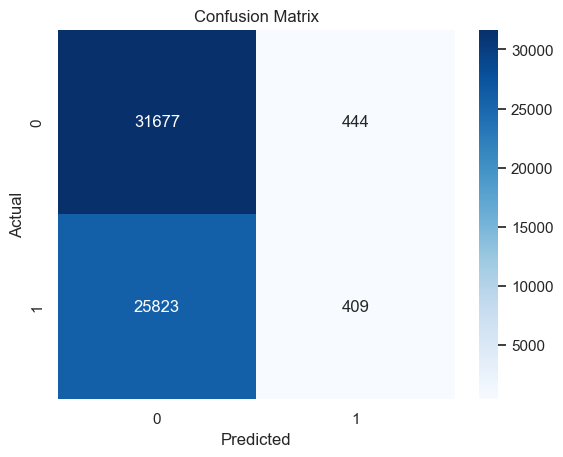

In [153]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Decision Tree

Model Accuracy: 0.55


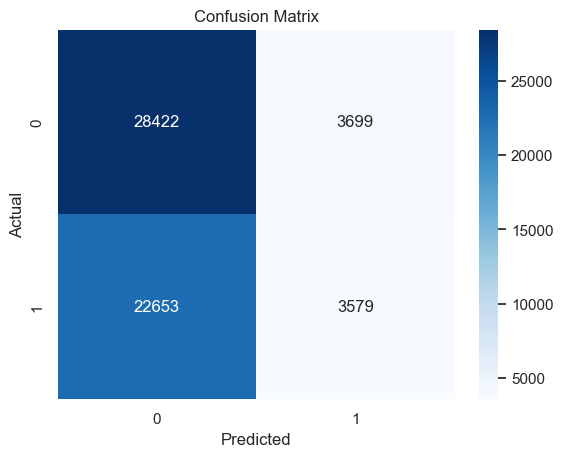

In [162]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=99, min_samples_split=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Results indicate that Ranking -> Result can not accurately be predicted.

## Rating to Performance correlation? (win/loss ratio)

In [200]:
total_games = games_df.groupby('player').size()
wins = games_df[games_df['result'] == 'win'].groupby('player').size()

wins = wins.reindex(total_games.index, fill_value=0)

win_loss_ratio = wins / total_games


avg_rating_diff = games_df.groupby("player")["rating_diff"].mean()

player_stats = pd.DataFrame(
    {"total_games": total_games, "wins": wins, "win_loss_ratio": win_loss_ratio}
)
player_stats = player_stats.join(avg_rating_diff)
player_stats


,total_games,wins,win_loss_ratio,rating_diff
player,,,,
0064chess,36,17,0.472222,264.694444
00jmd,1,0,0.000000,-287.000000
00rexxar00,2,2,1.000000,-621.500000
021_aguiar,1,1,1.000000,494.000000
02kasparov02,4,1,0.250000,-178.750000
...,...,...,...,...
zzzcn,1,0,0.000000,-7.000000
zzzeeeet,2,2,1.000000,-1388.000000
zzzmorgan,1,0,0.000000,-1354.000000


In [201]:
player_stats.corr()

,total_games,wins,win_loss_ratio,rating_diff
total_games,1.000000,0.992270,0.004994,0.077334
wins,0.992270,1.000000,0.024557,0.078966
win_loss_ratio,0.004994,0.024557,1.000000,0.052505
rating_diff,0.077334,0.078966,0.052505,1.000000


In [202]:
player_stats['win_loss_ratio'].describe()

count    19927.000000
mean         0.435004
std          0.399942
min          0.000000
25%          0.000000
50%          0.416667
75%          1.000000
max          1.000000
Name: win_loss_ratio, dtype: float64

In [229]:
player_stats_slim = player_stats[player_stats['total_games'] >= 5]
player_stats_slim['win_loss_ratio'].describe()

count    5019.000000
mean        0.432221
std         0.160546
min         0.000000
25%         0.333333
50%         0.433333
75%         0.523810
max         1.000000
Name: win_loss_ratio, dtype: float64

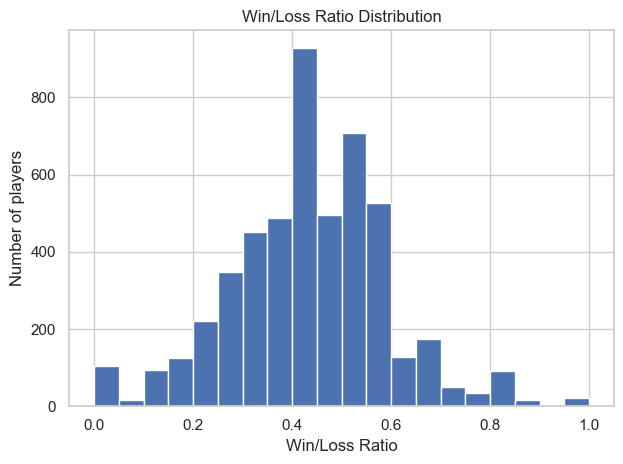

In [ ]:
plt.hist(player_stats_slim['win_loss_ratio'], bins=20)
plt.xlabel('Win/Loss Ratio')
plt.ylabel('Number of players')
plt.title('Win/Loss Ratio Distribution')
plt.tight_layout()
plt.show()

In [258]:
# They can be found!

win_rate_threshold = 0.95
game_count_threshold = 100
rating_threshold = 1200

filtered_players = player_stats[
    (player_stats['win_loss_ratio'] >= win_rate_threshold) &
    (player_stats['total_games'] >= game_count_threshold) &
    (player_stats['rating_diff'] <= rating_threshold)
]

filtered_players

,total_games,wins,win_loss_ratio,rating_diff,target
player,,,,,
findwaldo1,236,236,1.0,795.381356,1
findwaldo2,155,155,1.0,-1772.212903,1
findwaldo3,172,172,1.0,-394.308140,1
findwaldo5,120,120,1.0,-1461.008333,1


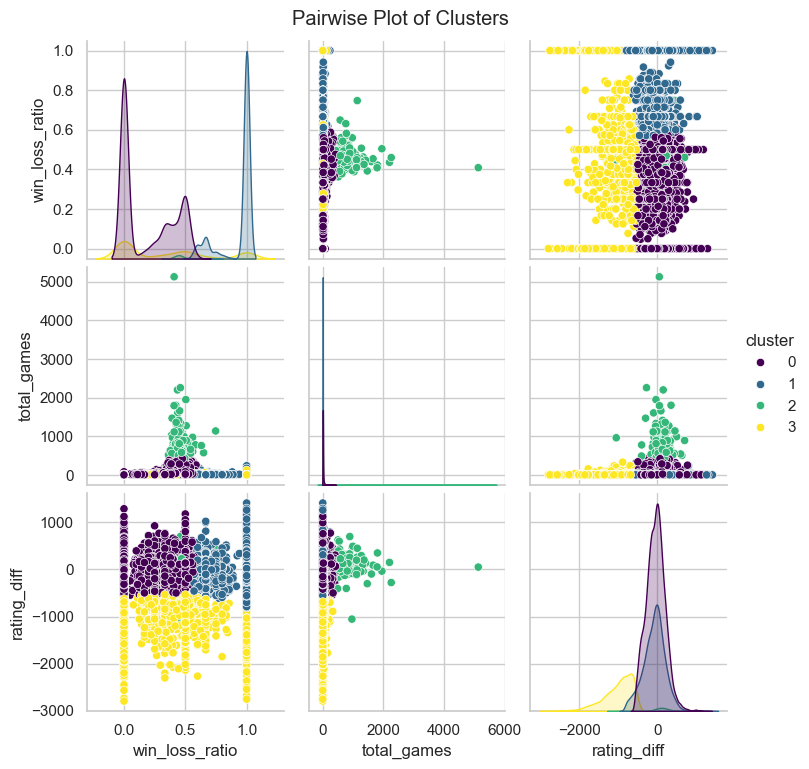

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = player_stats[["win_loss_ratio", "total_games", "rating_diff"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = KMeans(n_clusters=4, random_state=99)
player_stats["cluster"] = model.fit_predict(X_scaled)

sns.pairplot(
    player_stats,
    hue="cluster",
    vars=["win_loss_ratio", "total_games", "rating_diff"],
    palette="viridis",
)
plt.suptitle("Pairwise Plot of Clusters", y=1.02)
plt.show()


In [271]:
player_stats[['total_games', 'rating_diff']].corr()

,total_games,rating_diff
total_games,1.000000,0.077334
rating_diff,0.077334,1.000000


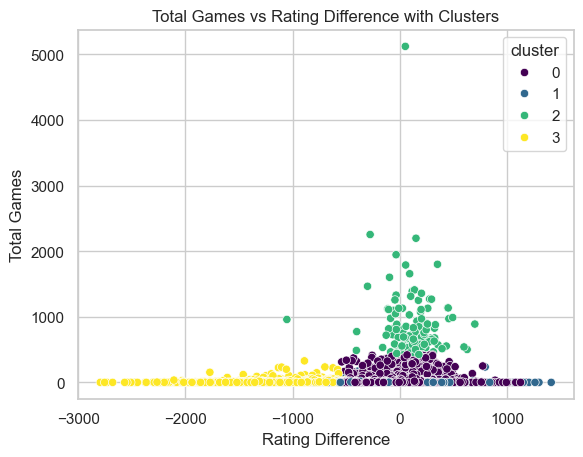

In [273]:
sns.scatterplot(
    x="rating_diff",
    y="total_games",
    hue="cluster",
    data=player_stats,
    palette="viridis",
)
plt.xlabel("Rating Difference")
plt.ylabel("Total Games")
plt.title("Total Games vs Rating Difference with Clusters")
plt.show()

## PageRank Analysis

In [ ]:
def calculate_pagerank(graph, alpha=0.85, max_iter=100, tol=1.0e-6):
    return nx.pagerank(graph, alpha=alpha, max_iter=max_iter, tol=tol)


pagerank_scores = calculate_pagerank(fake_g)
pagerank_scores

{'ecztery': 0.00017972608453598412,
 'zera_kv': 9.388457934567843e-05,
 'chesschief24': 0.0001409547123672159,
 'nebrabp': 9.333543967036496e-05,
 'crazymaxxx': 0.0004992962265100862,
 'elterrordelteorico': 5.341202912367417e-05,
 'mattydperrine': 0.0003329772078476181,
 'letsbefairenough': 0.00017710822518291204,
 'caterpiller35': 0.00010696579979697983,
 'firdavs_me': 6.0228862951543645e-05,
 'hristiyaniliev06': 0.00122562780233705,
 'agressiveitachi': 5.311483594494637e-05,
 'mattis1012': 7.301766236068688e-05,
 'albafantasmal': 8.8597827898772e-05,
 'vankyo02': 4.890299105940241e-05,
 'cortomusoallegro': 4.5800523470374234e-05,
 'h3nriquetv': 6.67372692133397e-05,
 'lilekoridze': 6.786516359215278e-05,
 'jcibarra': 0.00020047945038784764,
 'lschess': 0.0008664056725324629,
 'sadullo-a': 7.353757972281688e-05,
 'diogorogechesss': 2.334529423939658e-05,
 'chessbymemory': 3.864307050020742e-05,
 'zhaoheng': 0.001875366791288258,
 'asvz': 4.2597614890290823e-05,
 'gyg': 3.3517168403351

In [ ]:
import numpy as np


def identify_anomalies(pagerank_scores, threshold=2.0):
    scores = np.array(list(pagerank_scores.values()))
    mean = np.mean(scores)
    std_dev = np.std(scores)
    anomalies = {
        node: score
        for node, score in pagerank_scores.items()
        if abs(score - mean) > threshold * std_dev
    }
    return anomalies


anomalies = identify_anomalies(pagerank_scores)
list(anomalies.keys())

['hristiyaniliev06',
 'lschess',
 'zhaoheng',
 'last8pawns',
 'huskywithahat',
 'ethannorris2006',
 'orangeking2504',
 'jospem',
 'tikhon_popov',
 'pltanoocanario',
 'xchessfalconx',
 'oleksandr_bortnyk',
 'gmbenjaminbok',
 'boundless_strike',
 'danielnaroditsky',
 'daniellinikk',
 'flachess10',
 'miterryble',
 'penguingm1',
 'calmberserk',
 'microbear',
 'zmeeed67',
 'ilanschnaider',
 'tigrvshlyape',
 'icecreamiscream',
 'hikaru',
 'aquariusman2006',
 'rhwr',
 'tdaly123',
 'swordoftheword16',
 'chesssharkz',
 'gm_robertomogranzini',
 'tgpgoat',
 'evermusic1622',
 'abcdc',
 'dimailuka',
 'coryives',
 'nosleeptildeath',
 'bach12345_lfay',
 'orest_vovk',
 'fabianocaruana',
 'frederiksvane',
 'koncheto',
 'nicyflash777',
 'roacess275',
 'treasurechess777',
 'bobchuckyjoe',
 'munger_avenue',
 'juniorplankton',
 'lirbbb',
 'corbblah',
 'nicol3_e',
 'game2min',
 'yellowmamba303',
 'jahonas',
 'lucuix21',
 'dengzhili',
 'kreismyr',
 'freudlixo',
 'a4rooka3',
 'minas_tv',
 'manudavid2910',
 'c

PageRank may not be the best in identifying "cheaters", as anomalies here refer to high & low player pageranks, or those with significant or insignificant importance to the graph.

This is likely indicating players who play a lot with others (online), and players who don't play a lot (or play with friends).